# 4D In-situ XCT of Aerosol Filtration Data Analysis; Python Workflow
#### by Matthew Jones

### Introduction
About this dataset: We used 4D (3D + time) X-ray Computed Tomography (XCT) at the Diamond Light Source Sychrotron I13-2 beamline to image how a TiO2 aerosol deposited in the pores and on the walls of a filter. This data set allows us to observe the transition from Deep bed to Cake filtration. This data set has the potential to be integrated into image based simulations and verify models of aerosol filtration on porous media.

About this notebook: We will include the entire workflow that takes reconstructed data through to a segmented 4D (3D + time) data set. We first segment the zeroth (i.e. clean volume) into background and filter segments. The filter segment mask is applied to the subsequent volumes which have all been registered onto the zeroth volume. These registered and masked subseqent volumes are then segmented (i.e. the aerosol deposits are segmented). See steps below;
1. Clean Z-axis banding issue in data
2. Binarisation of the zeroth volume
3. Registration of the subsequent volumes onto the zeroth volume
4. Rescaling the data
5. Non-local means filtering of the entire set
6. Apply Global Threshold
7. Visualisation

### Step 1; Clean Z-axis banding issue in reconstructed data

We have a banding issue in the data set where the gray level of the background varies from z-slice to z-slice. We will rescale the data to remove the noise using the method below. This method defines the global maximum of a reference image histogram (usually the whole volume reshaped to 2D image) and then resamples the input image so that it's histogram max matches that of the reference.

In [ ]:
import imageio as io
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import imageio as io
import numpy as np

vol = io.volread('E:/paper_2/Volumes_Bare/TiffSaver-tomo_B0X.tif')
refimage = vol.reshape(-1)
image = vol[2105]

def equalise_globalmax_1(image, refimage):
    refhist = np.histogram(refimage.astype('Float32'), bins=range(256))
    imghist = np.histogram(image.astype('Float32'), bins=range(256))
    diff = refhist[0].tolist().index(max(refhist[0])) 
    - imghist[0].tolist().index(max(imghist[0]))                        
    resampled = image + diff
    return refhist, imghist, diff, resampled;

fig, axes = plt.subplots(ncols=1, nrows=3, figsize= (7, 7), sharex=True, sharey=False)
ax = axes.ravel()

refhist, imghist, diff, resampled = equalise_globalmax_1(image, refimage);

#ax[0].imshow(refimage, cmap=plt.cm.gray)
#ax[0].set_title('Reference')
#ax[0].axis('off')

ax[0].set_title('Reference Volume')
ax[0].hist(refimage.ravel(), bins=256)
ax[0].axvline(refhist[0].tolist().index(max(refhist[0])), color='r')
   
#ax[2].imshow(image, cmap=plt.cm.gray)
#ax[2].set_title('Original')
#ax[2].axis('off')
   
ax[1].set_title('Zth Slice')
ax[1].hist(image.ravel(), bins=256)
ax[1].axvline(imghist[0].tolist().index(max(imghist[0])), color='g')

#ax[4].imshow(resampled, cmap=plt.cm.gray)
#ax[4].set_title('Resampled')
#ax[4].axis('off')

ax[2].set_title('Resampled Slice to Reference')
ax[2].hist(resampled.ravel(), bins=256)
ax[2].axvline(refhist[0].tolist().index(max(refhist[0])), color='r')
ax[2].axvline(imghist[0].tolist().index(max(imghist[0])), color='g')

plt.show()

In [ ]:
#okay now we will loop z-slice through the function to process the entire volume
refhist = np.histogram(refimage.astype('Float32'), bins=range(256))
global_max = refhist[0].tolist().index(max(refhist[0]))

def equalise_globalmax_2(image, global_max):
    imghist = np.histogram(image.astype('Float32'), bins=range(256))
    diff = global_max - imghist[0].tolist().index(max(imghist[0]))                        
    resampled = image + diff
    return resampled;

for z in range(2110):
    vol[z] = equalise_globalmax_2(vol[z], global_max)

io.volwrite('E:/paper_2/Volumes_Bare/TiffSaver-tomo_B0X.tif', vol, format='tiff')

In [ ]:
#that worked nicely so now we apply this to the whole data set
for y in range(1, 17):
    vol = io.volread('E:/paper_2/Volumes_Bare/TiffSaver-tomo_B%d.tif'%(y))
    refimage = vol.reshape(-1)
    refhist = np.histogram(refimage.astype('Float32'), bins=range(256))
    global_max = refhist[0].tolist().index(max(refhist[0]))
    for z in range(2110):
        vol[z] = equalise_globalmax_2(vol[z], global_max)
    io.volwrite('E:/paper_2/Volumes_Bare/TiffSaver-tomo_B%d.tif'%(y), vol, format='tiff')

In [ ]:
#see result of this resampling operation in the image of excel plot below.
plot_img = io.imread('E:/paper_2/resample_noise.png')
plt.imshow(plot_img)
plt.axis('off')

### Step 2; Binarisation of the Zeroth (i.e. clean unloaded) Volume

As described in the introduction we now binarise (segment into filter & background) the zeroth volume. This is the volume that was aquired before the aerosol was flowed through the filter. Thus we can segment this filter into two binary segments only. Since there is significant grayscale overlap between the deposits and filter in the subsequent 4D volumes we will apply this zeroth mask to those volumes so that the deposits can be segmented accurately. 

In [ ]:
#Imports 
import numpy as np
import matplotlib.pyplot as plt
import imageio as io
from skimage import data, img_as_float
from skimage.io import imread_collection
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.util import crop
from skimage.morphology import binary_erosion, binary_dilation, cube
from skimage import filters
from skimage.filters import gaussian

#Read in data for zeroth volume. This will be used as mask for the filter/cat phase.
vol_0 = img_as_float(crop(io.volread('E:/paper_2/Volumes_Bare/TiffSaver-tomo_B0X.tif'),
                          ((0, 1055),(0, 0), (0, 0)), copy=True))

#2d wise non local means
sigma_est = np.mean(estimate_sigma(vol_0, multichannel=False))
for z in range(1055):
    vol_0[z] = denoise_nl_means(vol_0[z], h=4*sigma_est, fast_mode=True,
                                  patch_size=9, patch_distance=5, multichannel=False)
vol_0_nlm = vol_0 * 255

#Gaussian Filter
vol_0_gaussian = gaussian(vol_0_nlm, sigma=0.20, output=None, mode='nearest', cval=0,
                          multichannel=False, preserve_range=True, truncate=4.0)

#Apply binary threshold 1
thresh_yen_vol1 = filters.threshold_yen(vol_0_gaussian.astype('uint8'))
segmented_yen_vol_0 = vol_0_gaussian.astype('uint8') > thresh_yen_vol1 + 2

#Erosion/Dilation of binary 1
segmented_yen_eroded_vol_0_1=binary_erosion(segmented_yen_vol_0, cube(1))
segmented_yen_eroded_vol_0_2=binary_erosion(segmented_yen_eroded_vol_0_1, cube(1))
segmented_yen_eroded_vol_0=binary_erosion(segmented_yen_eroded_vol_0_2, cube(1))
segmented_yen_eroded_dilated_vol_0_1=binary_dilation(segmented_yen_eroded_vol_0, cube(1))
segmented_yen_eroded_dilated_vol_0_2=binary_dilation(segmented_yen_eroded_dilated_vol_0_1, cube(1))
#segmented_yen_eroded_dilated_vol_0_3=binary_dilation(segmented_yen_eroded_dilated_vol_0_2, cube(1))
segmented_yen_eroded_dilated_vol_0=binary_dilation(segmented_yen_eroded_dilated_vol_0_2, cube(1))

#Create mask
mask = 1 - segmented_yen_eroded_dilated_vol_0
#mask = 1 - segmented_yen_vol_0
masked_0 = vol_0_gaussian * mask

#Plot images of raw, filtered, threshold, threshold wt erosion/dilation
fig, axes = plt.subplots(nrows=5, ncols=1, figsize = (60, 18.4), 
                         sharex=True, sharey=True)
axes[0].imshow(vol_0[4], cmap = 'gray')
axes[1].imshow(vol_0_nlm[4], cmap = 'gray')
axes[2].imshow(segmented_yen_vol_0[4], cmap = 'gray')
axes[3].imshow(segmented_yen_eroded_dilated_vol_0[4], cmap='gray')
axes[4].imshow(masked_0[4], cmap='gray')

In [ ]:
#happy with the mask, save it.
#have to save as 2d slices to save memory
for y in range(0, 1055):
    io.imwrite('E:/paper_2/Volumes_Bare/Mask_TiffSaver/TiffSaver_%d.tif'%(y),
               mask[y].astype('Float32'), format='tiff')

**IMPORTANT NOTE:** This mask had to be loaded into Avizo so that streaking atefacts in the left wall could be manually removed using the paintbrush tool

### Step 3; Registration of subsequent 4D volumes onto the zeroth volume
Since we are going to apply the zeroth filter mask to all subsequent volumes in the data set it is important that the volumes are accuretly registered onto eachover (i.e. volumes are aligned). Otherwise this will mean that filter pixels are included in later deposit segments. Here we use the Simple ITK library to register volumes.

In [ ]:
#we will now register sebsequent volumes in the time series onto the binary volume from part 2
#it is critical the registration is good as initial binary will be aplied to subsequent volumes

from PIL import Image, ImageChops
import math
import numpy as np
import imageio as io
from skimage import img_as_float
from skimage.metrics import mean_squared_error as mse
from skimage.util import crop

#first we need to make some 'registration volumes' from the full volume so that sitk can
#read vol w/o mem err
for s in range(1, 17):
    load = io.volread('E:/paper_2/Volumes_Bare/TiffSaver-tomo_B%d.tif'%(s))
    crop = load[102:498, 302:498, 1002:1098]
    io.volwrite('E:/paper_2/Volumes_Bare/Registration_vol_bare/TiffSaver-reg_B%d.tif'%(s),
                crop, format='tiff')

load = io.volread('E:/paper_2/Volumes_Bare/TiffSaver-tomo_B0X.tif')
crop = load[102:498, 302:498, 1002:1098]
io.volwrite('E:/paper_2/Volumes_Bare/Registration_vol_bare/TiffSaver-reg_B0X.tif',
            crop, format='tiff')

In [ ]:
#function that calculates the root mean square error between im1 and im2
def rmsdiff(im1, im2):
    """Calculates the root mean square error (RSME) between two images"""
    return math.sqrt(mse(im1, im2))

#Loads and crops im1 and im2 for rmsdiff function
#loops im2 loader through t dimension in data series
im1 = io.volread('E:/paper_2/Volumes_Bare/Registration_vol_bare/TiffSaver-reg_B0X.tif')
.astype('Float32')
for x in range(1, 17):
    im2 = io.volread('E:/paper_2/Volumes_Bare/Registration_vol_bare/TiffSaver-reg_B%d.tif'%(x))
    .astype('Float32')
    print(f"RMS of tomo %d = {rmsdiff(im1[2:398, 2:198, 2:98], im2[2:398, 2:198, 2:98])}"%(x))

In [ ]:
#to check we have analysed correct shape/image region
import matplotlib.pyplot as plt
print(im1[2:398, 2:198, 2:98].shape)
plt.imshow(im1[200, 2:198, 2:98], cmap = 'gray')

In [ ]:
#that'll do
from __future__ import print_function
import SimpleITK as sitk
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from ipywidgets import interact, fixed

#the dimension of the image and the origin
dimension = 3
point = (1.0, 1.0, 1.0)
#this function will print where the origin will be translated to 
def transform_point(transform, point):
    transformed_point = transform.TransformPoint(point)
    print('Point ' + str(point) + ' transformed is ' + str(transformed_point))
#this function will visualises
def myshow(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayViewFromImage(img)
    spacing = img.GetSpacing()    
    ysize = nda.shape[0]
    xsize = nda.shape[1]  
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi
    fig = plt.figure(title, figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    extent = (0, xsize*spacing[1], 0, ysize*spacing[0])
    t = ax.imshow(nda,
            extent=extent,
            interpolation='hamming',
            cmap='gray',
            origin='lower')
    if(title):
        plt.title(title)

#this function executes the resampling
def resample(image, transform):
    # Output image Origin, Spacing, Size, Direction are taken from the reference
    # image in this call to Resample
    reference_image = image
    interpolator = sitk.sitkNearestNeighbor
    default_value = 0
    return sitk.Resample(image, reference_image, transform,
                         interpolator, default_value)
moving_image = sitk.ReadImage("E:/paper_2/Volumes_Bare/Registration_vol_bare/TiffSaver-reg_B1.tif",
                              sitk.sitkFloat32)
moving_image_cropped = moving_image[:, :, :] 
translation = sitk.TranslationTransform(dimension)
translation.SetParameters((0.0, 0.0, 0.0))
translation.SetOffset((0.0, 0.0, 0.0))
transform_point(translation, point)
resampled = resample(moving_image_cropped, translation)

In [ ]:
fixed_image = sitk.ReadImage("E:/paper_2/Volumes_Bare/Registration_vol_bare/TiffSaver-reg_B0X.tif",
                             sitk.sitkFloat32)
fixed_image_cropped = fixed_image[:, :, :]
translation_0 = sitk.TranslationTransform(dimension)
translation_0.SetParameters((0.0, 0.0, 0.0))
translation_0.SetOffset((0.0, 0.0, 0.0))
transform_point(translation_0, point)
resampled_0 = resample(fixed_image_cropped, translation_0)

In [ ]:
RMS0 = (sitk.GetArrayFromImage(resampled_0[2:98, 2:198, 2:398]))
RMS1 = (sitk.GetArrayFromImage(resampled[2:98, 2:198, 2:398]))
print(rmsdiff(RMS0, RMS1)) #this has to equal the value originally calculated up top or something is off

In [ ]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image_cropped, 
                                                      moving_image_cropped, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMeanSquares()
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)
registration_method.SetInterpolator(sitk.sitkNearestNeighbor)  
#This is the least computationally demanding interpolator 
registration_method.SetOptimizerAsExhaustive(numberOfSteps=[0,0,0,20,10,10], stepLength = 1) 
registration_method.SetOptimizerScales([1,1,1,1,1,1])

#Perform the registration in-place so that the initial_transform is modified.
registration_method.SetInitialTransform(initial_transform, inPlace=True)
registration_method.Execute(fixed_image_cropped, moving_image_cropped)

print('course initial transform is: ' + str(initial_transform.GetParameters()))

In [ ]:
translation_test = sitk.TranslationTransform(dimension)
translation_test.SetParameters((1.0, -3.0, 3.0)) #put the best transform from above here!!!
translation.SetOffset((1.0, -3.0, 3.0)) ##put the best transform from above here!!!
transform_point(translation_test, point)
resampled_test = resample(moving_image_cropped, translation_test)
myshow(resampled_test[10, :, :], 'Resampled Translation')

In [ ]:
RMS0_test = (sitk.GetArrayFromImage(resampled_0[2:98, 2:198, 2:398])).astype('uint8')
RMS1_test = (sitk.GetArrayFromImage(resampled_test[2:98, 2:198, 2:398])).astype('uint8')
print(rmsdiff(RMS0_test, RMS1_test))

In [ ]:
# we have shown that this method improves the registration of the subsequent grayscale images 
#onto the binary i.e because the RMSE is less after the translation
# now we loop the volumes through the above code in order to apply to the whole set
for x in range(1, 17):
    initial_transform = sitk.CenteredTransformInitializer(fixed_image_cropped, 
                                                      moving_image_cropped, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMeanSquares()
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    registration_method.SetInterpolator(sitk.sitkNearestNeighbor)  
    #This is the least computationally demanding interpolator 
    registration_method.SetOptimizerAsExhaustive(numberOfSteps=[0,0,0,20,10,10], stepLength = 1) 
    registration_method.SetOptimizerScales([1,1,1,1,1,1])
    moving_image = sitk.ReadImage("E:/paper_2/Volumes_Bare/Registration_vol_bare/TiffSaver-reg_B%d.tif"%(x)
                                  , sitk.sitkFloat32)
    moving_image_cropped = moving_image[:, :, :]
    registration_method.SetInitialTransform(initial_transform, inPlace=True)
    registration_method.Execute(fixed_image_cropped, moving_image_cropped)
    print('best transformation %d: '%(x) + str(initial_transform.GetParameters()))

In [ ]:
#Ok! Let's now apply the translations to the data set

from __future__ import print_function
import SimpleITK as sitk
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from ipywidgets import interact, fixed

dimension = 3
def resample(image, transform):
    # Output image Origin, Spacing, Size, Direction are taken from the reference
    # image in this call to Resample
    reference_image = image
    interpolator = sitk.sitkNearestNeighbor
    default_value = 0
    return sitk.Resample(image, reference_image, transform,
                         interpolator, default_value)

#had to crop and save some smaller volumes to stop mem errors
#import imageio as io
#for x in range(1, 17):
    #imga = io.volread('E:/paper_2/Volumes_Bare/TiffSaver-tomo_B%d.tif'%(x))[:1055, :, :]
    #imgb = io.volread('E:/paper_2/Volumes_Bare/TiffSaver-tomo_B%d.tif'%(x))[1055:, :, :]
    #io.volwrite('E:/paper_2/Volumes_Bare/TiffSaver-tomo_B%d_a.tif', imga, format='tiff')
    #io.volwrite('E:/paper_2/Volumes_Bare/TiffSaver-tomo_B%d_b.tif', imgb, format='tiff')

#make lists
#these params where calculated above from the registration process but with the inital transform 
#added into the params this initial transform is from the cropping process and not the
#initial tranform from the reg above

param_1 = (1.0, -3.0, 3.0)
param_2 = (1.0, -2.0, 3.0)
param_3 = (1.0, -2.0, 3.0)
param_4 = (1.0, -3.0, 3.0)
param_5 = (1.0, -3.0, 3.0)
param_6 = (0.0, -3.0, 3.0)
param_7 = (0.0, -3.0, 3.0)
param_8 = (0.0, -3.0, 3.0)
param_9 = (1.0, -3.0, 3.0)
param_10 = (1.0, -3.0, 3.0)
param_11 = (0.0, -3.0, 4.0)
param_12 = (0.0, -3.0, 4.0)
param_13 = (0.0, -3.0, 4.0)
param_14 = (0.0, -3.0, 4.0)
param_15 = (0.0, -3.0, 4.0)
param_16 = (0.0, -3.0, 4.0)

parameters = [param_1, param_2, param_3, param_4, param_5, param_6, param_7, param_8,
              param_9, param_10, param_11, param_12, param_13, param_14, param_15, param_16]
resampled_list = ['r_1', 'r_2', 'r_3', 'r_4', 'r_5', 'r_6', 'r_7', 'r_8', 'r_9', 'r_10',
                  'r_11', 'r_12', 'r_13', 'r_14', 'r_15', 'r_16']

for x in range(9, 16):
    image = sitk.ReadImage("E:/paper_2/Volumes_Bare/TiffSaver-tomo_B%d_b.tif"%(x+1), sitk.sitkFloat32)
    translation = sitk.TranslationTransform(dimension)
    translation.SetParameters(parameters[x])
    translation.SetOffset(parameters[x])
    resampled_list[x] = resample(image, translation)

In [ ]:
import imageio as io
#now save these for future segmentation
for z in range(9, 16):
    io.volsave('E:/paper_2/Volumes_Bare/Registered_vols/TiffSaver-tomo_B%d_b.tif'%(z+1),  
               sitk.GetArrayFromImage(resampled_list[z]).astype(np.uint8), format='tiff')

In [ ]:
#in sitk it is possible to do even finer sub pixel translations because the image is 
#considered to bound a physical space rather than discrete pixel locations
#we will now apply a finer registration

moving_image = sitk.ReadImage('E:/paper_2/Volumes_Bare/Registered_vols/TiffSaver-tomo_B1_a.tif'
                              , sitk.sitkFloat32)
moving_image_cropped = moving_image[1010:1090, 310:490, 110:490]
fixed_image = sitk.ReadImage('E:/paper_2/Volumes_Bare/TiffSaver-tomo_B0X.tif', sitk.sitkFloat32)
fixed_image_cropped = fixed_image[1010:1090, 310:490, 110:490]
    
for l in range(1, 17):
    initial_transform = sitk.CenteredTransformInitializer(fixed_image_cropped, 
                                                      moving_image_cropped, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMeanSquares()
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    registration_method.SetInterpolator(sitk.sitkNearestNeighbor)  
    #This is the least computationally demanding interpolator 
    registration_method.SetOptimizerAsExhaustive(numberOfSteps=[0,0,0,10,10,10], stepLength = 0.1) 
    registration_method.SetOptimizerScales([1,1,1,1,1,1])
    moving_image = sitk.ReadImage('E:/paper_2/Volumes_Bare/Registered_vols/TiffSaver-tomo_B%d_a.tif'%(l)
                                  , sitk.sitkFloat32)
    moving_image_cropped = moving_image[1010:1090, 310:490, 110:490]
    registration_method.SetInitialTransform(initial_transform, inPlace=True)
    registration_method.Execute(fixed_image_cropped, moving_image_cropped)
    print('best transformation %d: '%(l) + str(initial_transform.GetParameters()))

In [ ]:
#Ok! Let's now apply the translations to the data set

from __future__ import print_function
import SimpleITK as sitk
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from ipywidgets import interact, fixed

dimension = 3
def resample(image, transform):
    # Output image Origin, Spacing, Size, Direction are taken from the reference
    # image in this call to Resample
    reference_image = image
    interpolator = sitk.sitkNearestNeighbor
    default_value = 0
    return sitk.Resample(image, reference_image, transform,
                         interpolator, default_value)

params_1 = (0.0, 0.0, 0.0)
params_2 = (0.0, 0.0, 0.0)
params_3 = (0.0, 0.0, 0.0)
params_4 = (0.0, 0.0, 0.0)
params_5 = (-0.9, 0.0, 0.0)
params_6 = (0.0, 0.0, 0.0)
params_7 = (0.1, 0.0, 0.0)
params_8 = (0.6000000000000001, 0.0, 0.0)
params_9 = (0.0, 0.0, 0.0)
params_10 = (0.0, 0.0, 0.0)
params_11 = (0.0, 0.0, 0.0)
params_12 = (0.0, 0.0, 0.0)
params_13 = (0.0, 0.0, 0.0)
params_14 = (0.0, 0.0, 0.0)
params_15 = (0.0, 0.0, 0.0)
params_16 = (0.0, 0.0, 0.0)

parameters_1 = [params_1, params_2, params_3, params_4, params_5, params_6, params_7, params_8,
              params_9, params_10, params_11, params_12, params_13, params_14, params_15, params_16]
resampled_list_1 = ['r_1', 'r_2', 'r_3', 'r_4', 'r_5', 'r_6', 'r_7', 'r_8', 'r_9', 'r_10', 'r_11', 'r_12',
                  'r_13', 'r_14', 'r_15', 'r_16']
for x in range(9, 16):
    image = sitk.ReadImage('E:/paper_2/Volumes_Bare/Registered_vols/TiffSaver-tomo_B%d_b.tif'%(x+1)
                           , sitk.sitkFloat32)
    translation = sitk.TranslationTransform(dimension)
    translation.SetParameters(parameters_1[x])
    translation.SetOffset(parameters_1[x])
    resampled_list_1[x] = resample(image, translation)

In [ ]:
import imageio as io
for x in range(9, 16):
    io.volsave('E:/paper_2/Volumes_Bare/Registered_vols/TiffSaver-tomo_B%d_b.tif'%(x+1), 
               sitk.GetArrayFromImage(resampled_list_1[x]).astype(np.uint8), format='tiff')

### Step 4; Rescaling the Data 4D
The average and background gray level move around from 4D volume to 4D volume. In order to be able to apply a global threshold to all the set we want pixels to all be in the same relative range. Thus we rescale, using a simialar method to step 1. 

In [ ]:
#here we will rescale all volumes so that the global maximum is 
#at the same gray intensity across the whole set
import matplotlib.pyplot as plt
import imageio as io
import numpy as np

def rescale_4D(image, rescale_to_value):
    imghist = np.histogram(image.astype('Float32'), bins=range(256))
    diff = rescale_to_value - imghist[0].tolist().index(max(imghist[0]))                        
    resampled = image + diff
    return resampled;

Ref_vol = io.volread('E:/paper_2/Volumes_Bare/TiffSaver-tomo_B0X.tif')
refimage = Ref_vol.reshape(-1)
refhist = np.histogram(refimage.astype('Float32'), bins=range(256))
rescale_to_value = refhist[0].tolist().index(max(refhist[0]))

for x in range(1, 17):
    image = io.volread('E:/paper_2/Volumes_Bare/Registered_vols/TiffSaver-tomo_B%d_a.tif'%(x))
    resampled = rescale_4D(image, rescale_to_value)
    io.volwrite('E:/paper_2/Volumes_Bare/Registered_vols/TiffSaver-tomo_B%d_a.tif'%(x),
                resampled, format='tiff')

### Step 5; Apply Non-local Means Filter to Whole Set
In-order to segment the deposit phase in the next steps we need to smooth the image so that noise does not effect the segmentation. Here we apply the same nlm parameters as used in step 2 to the whole data set. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio as io
from skimage import data, img_as_float
from skimage.io import imread_collection
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.util import crop
from skimage.morphology import binary_erosion, binary_dilation, cube
from skimage import filters
from skimage.filters import gaussian

vol_0 = img_as_float(io.volread('E:/paper_2/Volumes_Bare/TiffSaver-tomo_B0X.tif'))
sigma_est_B0X = np.mean((estimate_sigma(vol_0, multichannel=False)))
for z in range(2110):
    vol_0[z] = denoise_nl_means(vol_0[z], h=4*sigma_est_B0X, fast_mode=True,
                                patch_size=9, patch_distance=5, multichannel=False)
vol_0_nlm = vol_0 * 255    
vol_0_gaussian = gaussian(vol_0_nlm, sigma=0.20, output=None, mode='nearest', cval=0, 
                          multichannel=False, preserve_range=True, truncate=4.0)
for w in range(2110):
    io.imwrite('E:/paper_2/Volumes_Bare/Registered_vols/TiffSaver-tomo_B0X/TiffSaver-tomo_B0X_%d.tif'%(w),
               vol_0_gaussian[w].astype(np.uint8), format='tiff')

In [ ]:
#2d wise non local means & gaussian of whole 4d set
for l in range(2, 17):
    vol_0 = img_as_float
    (io.volread('E:/paper_2/Volumes_Bare/Registered_vols/TiffSaver-tomo_B%d_a.tif'%(l)))
    sigma_est_a = np.mean(estimate_sigma(vol_0, multichannel=False))
    for z in range(1055):
        vol_0[z] = denoise_nl_means(vol_0[z], h=4*sigma_est_a, fast_mode=True, 
                                    patch_size=9, patch_distance=5, multichannel=False)
    vol_0_nlm = vol_0 * 255
    vol_0_gaussian = gaussian(vol_0_nlm, sigma=0.20, output=None, mode='nearest', cval=0,
                                  multichannel=False, preserve_range=True, truncate=4.0)
    io.volwrite('E:/paper_2/Volumes_Bare/Registered_vols/TiffSaver-tomo_B%d_a.tif'%(l), 
                vol_0_gaussian.astype(np.uint8), format='tiff')

for l in range(1, 17):
    vol_0 = img_as_float
    (io.volread('E:/paper_2/Volumes_Bare/Registered_vols/TiffSaver-tomo_B%d_b.tif'%(l)))
    sigma_est_b = np.mean(estimate_sigma(vol_0, multichannel=False))
    for z in range(1055):
        vol_0[z] = denoise_nl_means(vol_0[z], h=4*sigma_est_b, fast_mode=True, 
                                    patch_size=9, patch_distance=5, multichannel=False)
    vol_0_nlm = vol_0 * 255
    vol_0_gaussian = gaussian(vol_0_nlm, sigma=0.20, output=None, mode='nearest', cval=0,
                                  multichannel=False, preserve_range=True, truncate=4.0)
    io.volwrite('E:/paper_2/Volumes_Bare/Registered_vols/TiffSaver-tomo_B%d_b.tif'%(l), 
                vol_0_gaussian.astype(np.uint8), format='tiff')

### Step 6; Apply global threshold and save segmented volumes
Now that the data has been properly clean and organised it is possible to segment using a global threshold across the entire 4D data set. Various volumes are saved for later analysis.


In [ ]:
import imageio as io
import numpy as np
from skimage.morphology import binary_erosion, binary_dilation, cube

#we are going to apply a global TiO2 deposit threshold across
#the entire 4D data set and create segmented labelled volumes
filter_seg_a = io.volread('E:/paper_2/Volumes_Bare/Mask_TiffSaver_a.tif')
filter_seg_b = io.volread('E:/paper_2/Volumes_Bare/Mask_TiffSaver_b.tif')
channel_mask_a = io.volread('E:/paper_2/Volumes_Bare/Channel_Mask_TiffSaver.tif')[:1055, :, :]
channel_mask_b = io.volread('E:/paper_2/Volumes_Bare/Channel_Mask_TiffSaver.tif')[1055:, :, :]
thresh = 119

for x in range(1, 17):
    vol = io.volread('E:/paper_2/Volumes_Bare/Registered_vols/TiffSaver-tomo_B%d_a.tif'%(x))
    vol_TiO2_bed = (vol * (1 - filter_seg_a)) * channel_mask_a > thresh
    vol_TiO2_cake = (vol * (1 - filter_seg_a)) * (1 - channel_mask_a) > thresh
    vol_TiO2_cake = binary_erosion(vol_TiO2_cake, cube(3))
    vol_TiO2_cake = binary_dilation(vol_TiO2_cake, cube(3))
    vol_TiO2 = vol_TiO2_cake + vol_TiO2_bed
    io.volwrite('E:/paper_2/Volumes_Bare/TiO2_vols/TiO2_vol_%da.tif'%(x), vol_TiO2.astype(np.uint8), format='tiff')
    segmented = filter_seg_a + (2 * vol_TiO2) # background = 0, filter = 1, TiO2 = 2
    io.volwrite('E:/paper_2/Volumes_Bare/Segmented_vols/Segmented_vol_%da.tif'%(x), segmented.astype(np.uint8), format='tiff')

for x in range(1, 17):
    vol = io.volread('E:/paper_2/Volumes_Bare/Registered_vols/TiffSaver-tomo_B%d_b.tif'%(x))
    vol_TiO2_bed = (vol * (1 - filter_seg_b)) * channel_mask_b > thresh
    vol_TiO2_cake = (vol * (1 - filter_seg_b)) * (1 - channel_mask_b) > thresh
    vol_TiO2_cake = binary_erosion(vol_TiO2_cake, cube(3))
    vol_TiO2_cake = binary_dilation(vol_TiO2_cake, cube(3))
    vol_TiO2 = vol_TiO2_cake + vol_TiO2_bed
    io.volwrite('E:/paper_2/Volumes_Bare/TiO2_vols/TiO2_vol_%db.tif'%(x), vol_TiO2.astype(np.uint8), format='tiff')
    segmented = filter_seg_b + (2 * vol_TiO2) # background = 0, filter = 1, TiO2 = 2
    io.volwrite('E:/paper_2/Volumes_Bare/Segmented_vols/Segmented_vol_%db.tif'%(x), segmented.astype(np.uint8), format='tiff')

In [ ]:
import imageio as io
import numpy as np

for x in range(1, 17):
    vol = io.volread('E:/paper_2/Volumes_Bare/Registered_vols/TiffSaver-tomo_B%d_a.tif'%(x))
    vol_TiO2 = io.volread('E:/paper_2/Volumes_Bare/TiO2_vols/TiO2_vol_%da.tif'%(x))
    TiO2_gray_vol = (vol * vol_TiO2)
    io.volwrite('E:/paper_2/Volumes_Bare/TiO2_vols/TiO2_vol_gray_%da.tif'%(x), TiO2_gray_vol.astype(np.uint8), format='tiff')
    
for x in range(1, 17):
    vol = io.volread('E:/paper_2/Volumes_Bare/Registered_vols/TiffSaver-tomo_B%d_b.tif'%(x))
    vol_TiO2 = io.volread('E:/paper_2/Volumes_Bare/TiO2_vols/TiO2_vol_%db.tif'%(x))
    TiO2_gray_vol = (vol * vol_TiO2)
    io.volwrite('E:/paper_2/Volumes_Bare/TiO2_vols/TiO2_vol_gray_%db.tif'%(x), TiO2_gray_vol.astype(np.uint8), format='tiff')

### Step 7; Visualisation
The volumes from step 6 are loaded, cropped and saved for analysis in Avizo. In avizo the volumes are rendered. Below we show segmented rendering of the filter and background and intensity (physics colour map) of the TiO2 phase.

In [ ]:
import imageio as io
import numpy as np
#create small 'visualisation' volumes 250x250x250 upper right channel wall
mask_a_vis = io.volread('E:/paper_2/Volumes_Bare/Mask_TiffSaver_a.tif')[0:250, 428:678, 852:1102]
mask_b_vis = io.volread('E:/paper_2/Volumes_Bare/Mask_TiffSaver_b.tif')[:250, 340:590, 834:1084]
io.volwrite('E:/paper_2/Volumes_Bare/Visualisation_vols/mask_a_vis.tif', mask_a_vis, format='tiff')
io.volwrite('E:/paper_2/Volumes_Bare/Visualisation_vols/mask_b_vis.tif', mask_b_vis, format='tiff')

for x in range(1, 17):
    TiO2_vol_gray_vis = io.volread('E:/paper_2/Volumes_Bare/TiO2_vols/TiO2_vol_gray_%da.tif'%(x))[0:250, 428:678, 852:1102]
    TiO2_vol_vis = io.volread('E:/paper_2/Volumes_Bare/TiO2_vols/TiO2_vol_%da.tif'%(x))[0:250, 428:678, 852:1102]
    io.volwrite('E:/paper_2/Volumes_Bare/Visualisation_vols/TiO2_vol_gray_%da.tif'%(x), TiO2_vol_gray_vis, format='tiff')
    io.volwrite('E:/paper_2/Volumes_Bare/Visualisation_vols/TiO2_vol_%da.tif'%(x), TiO2_vol_vis, format='tiff')

for x in range(1, 17):
    TiO2_vol_gray_vis = io.volread('E:/paper_2/Volumes_Bare/TiO2_vols/TiO2_vol_gray_%db.tif'%(x))[:250, 340:590, 834:1084]
    TiO2_vol_vis = io.volread('E:/paper_2/Volumes_Bare/TiO2_vols/TiO2_vol_%db.tif'%(x))[:250, 340:590, 834:1084]
    io.volwrite('E:/paper_2/Volumes_Bare/Visualisation_vols/TiO2_vol_gray_%db.tif'%(x), TiO2_vol_gray_vis, format='tiff')
    io.volwrite('E:/paper_2/Volumes_Bare/Visualisation_vols/TiO2_vol_%db.tif'%(x), TiO2_vol_vis, format='tiff')

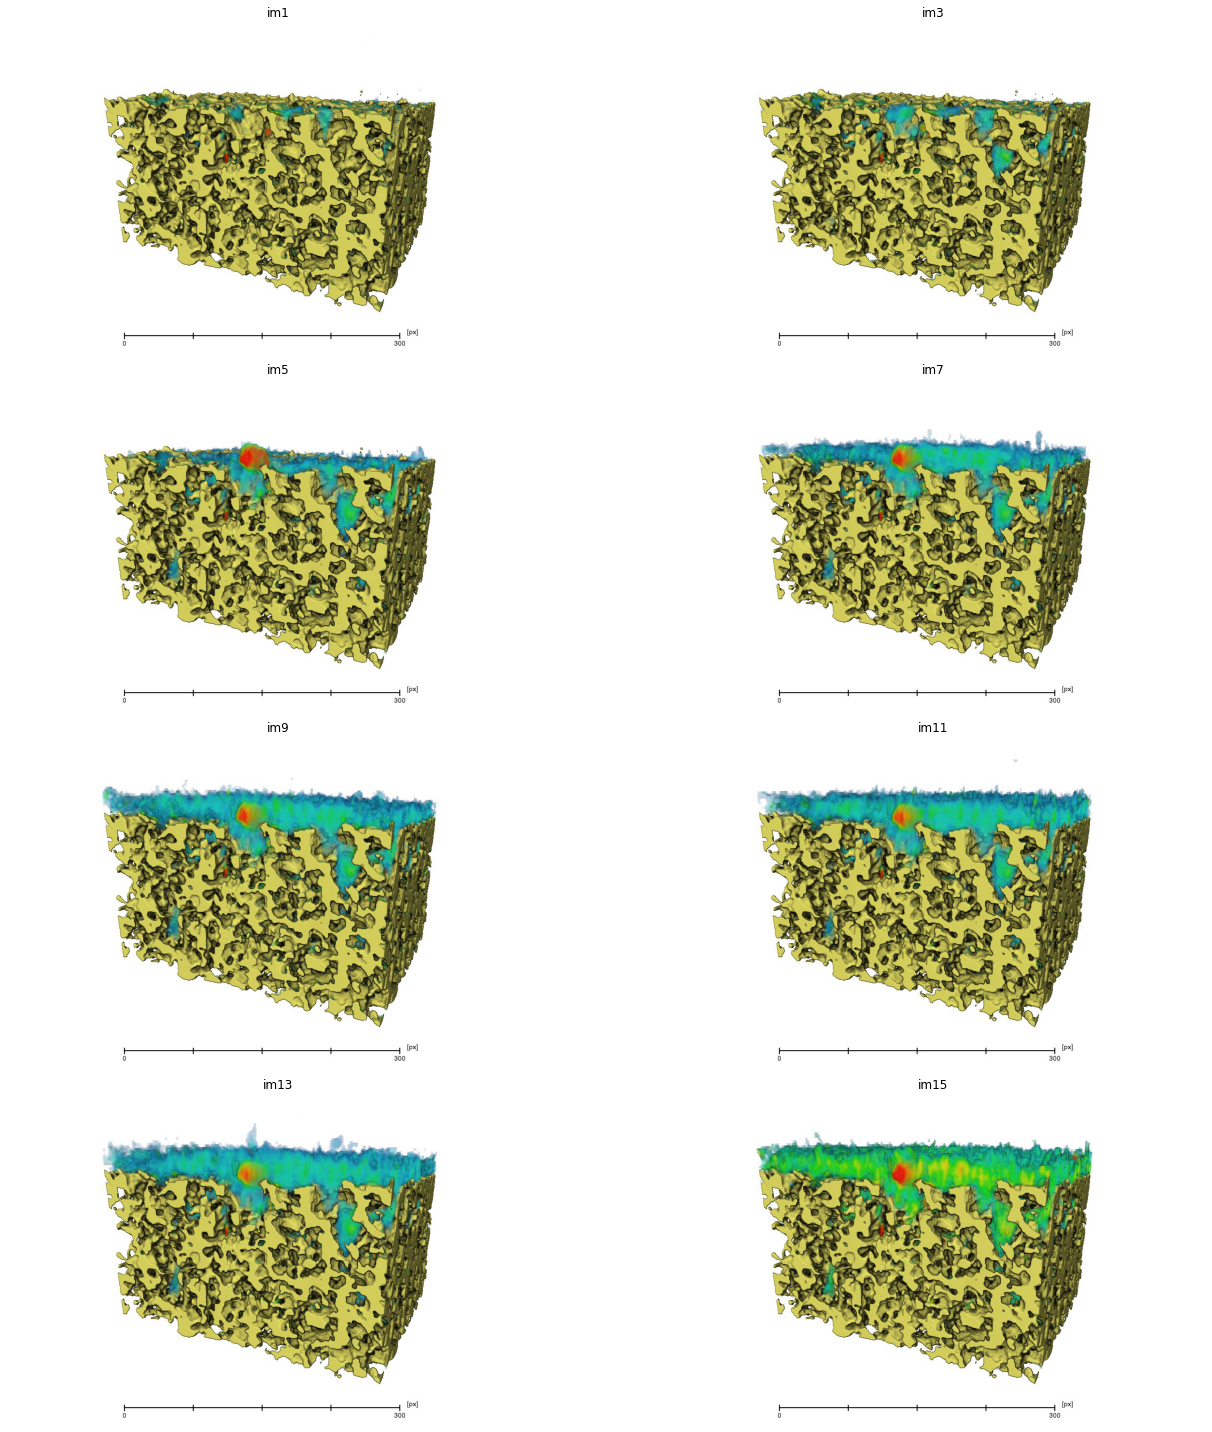

In [1]:
import imageio as io
import numpy as np
import matplotlib.pyplot as plt
#we then render the volumes in avizo as shown below. 
#Here we have rendered the segmented filter/background and the TiO2 in grayscale. 
#This means we can render the TiO2 with a color intensity map as shown below
#useful assuming intensity is proportional to deposit density 

im1 = io.imread('E:/paper_2/Volumes_Bare/avizo_snap_1a.jpg')
im3 = io.imread('E:/paper_2/Volumes_Bare/avizo_snap_3a.jpg')
im5 = io.imread('E:/paper_2/Volumes_Bare/avizo_snap_5a.jpg')
im7 = io.imread('E:/paper_2/Volumes_Bare/avizo_snap_7a.jpg')
im9 = io.imread('E:/paper_2/Volumes_Bare/avizo_snap_9a.jpg')
im11 = io.imread('E:/paper_2/Volumes_Bare/avizo_snap_11a.jpg')
im13 = io.imread('E:/paper_2/Volumes_Bare/avizo_snap_13a.jpg')
im15 = io.imread('E:/paper_2/Volumes_Bare/avizo_snap_15a.jpg')

fig, axes = plt.subplots(ncols=2, nrows=4, figsize= (20, 20), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(im1, cmap=plt.cm.gray)
ax[0].set_title('im1')
ax[0].axis('off')
ax[1].imshow(im3, cmap=plt.cm.gray)
ax[1].set_title('im3')
ax[1].axis('off')
ax[2].imshow(im5, cmap=plt.cm.gray)
ax[2].set_title('im5')
ax[2].axis('off')
ax[3].imshow(im7, cmap=plt.cm.gray)
ax[3].set_title('im7')
ax[3].axis('off')
ax[4].imshow(im9, cmap=plt.cm.gray)
ax[4].set_title('im9')
ax[4].axis('off')
ax[5].imshow(im11, cmap=plt.cm.gray)
ax[5].set_title('im11')
ax[5].axis('off')
ax[6].imshow(im13, cmap=plt.cm.gray)
ax[6].set_title('im13')
ax[6].axis('off')
ax[7].imshow(im15, cmap=plt.cm.gray)
ax[7].set_title('im15')
ax[7].axis('off')
plt.tight_layout()
plt.show()
